In [ ]:
!pip install umap-learn

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
from statistics import stdev

In [ ]:
# /content is the default directory of Google Colab. Googel Drive needs to be mounted in order to access the My Drive directory
from google.colab import drive
import os
current_wd = os.getcwd()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/Colab_Notebooks')

In [ ]:
def save_picture(fig, picture_name):
  previous_wd = os.getcwd()
  os.chdir('/content/drive/MyDrive/Colab Notebooks/GitHub_Pictures')
  fig.savefig(f'{picture_name}.jpeg', bbox_inches='tight')
  os.chdir(previous_wd)

In [ ]:
def get_us_pw(website):
  # Saves the current directory in a variable in order to switch back to it once the program ends
  previous_wd = os.getcwd()
  os.chdir('/content/drive/MyDrive')

  db = pd.read_excel('get_us_pw.xlsx', index_col=0)
  username = db.loc[website, 'Username']
  pw = db.loc[website, 'Password']
  base_url = db.loc[website, 'Base URL']

  os.chdir(previous_wd)

  return username, base_url, pw

In [ ]:
from sqlalchemy import create_engine
*username, pw = get_us_pw('PostgreSQL')
engine = create_engine(f"postgresql+psycopg2://{username[0]}:{pw}@{username[1]}:5432/nj_realtor_data")

In [ ]:
# Load dataset
data = pd.read_sql_table('nj_realtor_final_v2', engine)
pd.set_option('display.max_columns', None)
data.head()

,Municipality,County,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),NL% of Total Inventory (State),NL% of Total Inventory (County),County Sales Attr. By City,State Sales Attr. By City,County Inventory Attr. By City,State Inventory Attr. By City,County New Listings Attr. By City,State New Listings Attr. By City,Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Bicycle,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Total Population Estimate,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,EMP,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,AVG PAYANN PER EMP,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
0,Aberdeen Twp,Monmouth County,2019,12.500000,-0.311500,14.000000,-0.176250,57.000000,0.053250,363375.000000,0.055750,0.978000,-0.015250,39.500000,-0.215250,2.525000,-0.269000,-0.022591,-0.223178,0.017749,-0.023810,0.004625,-0.107463,-0.089637,0.000600,0.007334,0.038280,0.003377,0.023302,0.001989,0.029849,0.002547,40.430068,-74.225075,973.99,81.7,11.7,0.7,0.1,4.9,37.4,3.1,101363.0,45785,39.709677,40.0,18540.0,18.7,29.2,1.900000,95.6,4.4,64.3,14.0,21.4,37.8,23.5,2.1,74.5,25.5,74.3,2495.0,1670.0,0.02612,6340.0,300133.373800,7839.48,49.70,0.651583,19352.0,1278.0,15567.0,66.04,12.18,73283.42,1140803.0,2.0,1.0,1.0,113.57
1,Aberdeen Twp,Monmouth County,2020,19.090909,0.102182,14.727273,0.000182,52.181818,0.050091,388713.636364,0.069273,0.998273,0.022000,31.090909,-0.447182,2.100000,-0.411636,0.025417,0.032822,0.164538,0.151227,0.003137,-0.039063,-0.043888,0.000952,0.010883,0.023176,0.002073,0.017825,0.001556,0.025203,0.002366,40.430068,-74.225075,680.16,78.2,11.6,0.8,0.3,7.6,37.8,8.5,108132.0,50392,36.548387,41.7,18729.0,22.6,26.8,7.760377,96.9,3.1,64.9,16.3,20.9,38.5,21.2,1.9,75.5,24.5,71.6,2382.0,1691.0,0.02536,6347.0,312721.867024,7930.63,50.34,0.651583,19288.0,1278.0,15567.0,66.26,12.18,73283.42,1140803.0,2.0,1.0,1.0,123.89
2,Aberdeen Twp,Monmouth County,2021,17.833333,-0.023250,16.083333,0.243333,34.083333,-0.258500,476864.583333,0.227917,1.022500,0.028333,22.833333,-0.431083,1.391667,-0.498833,0.020368,0.077641,0.131135,0.075500,0.002372,-0.001872,0.004797,0.001090,0.013922,0.025648,0.002206,0.017596,0.001383,0.023844,0.002092,40.430068,-74.225075,391.76,76.7,10.3,0.8,0.3,10.4,36.9,5.9,111964.0,54145,31.416667,41.3,19184.0,22.5,26.4,2.800000,96.6,3.4,63.5,16.4,21.2,37.4,21.5,2.3,74.6,25.4,71.8,2438.0,1850.0,0.02524,6346.0,317217.048535,8006.56,50.81,0.583708,19350.0,1278.0,15567.0,66.05,12.18,73283.42,1140803.0,2.0,1.0,1.0,121.85
3,Aberdeen Twp,Monmouth County,2022,16.000000,-0.088000,12.083333,-0.340083,31.250000,-0.087917,535429.166667,0.159000,1.027833,

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2204 entries, 0 to 2203
Data columns (total 80 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Municipality                                                    2204 non-null   object 
 1   County                                                          2204 non-null   object 
 2   Year                                                            2204 non-null   int64  
 3   New Listings                                                    2204 non-null   float64
 4   New Listing % Change (YoY)                                      2204 non-null   float64
 5   Closed Sales                                                    2204 non-null   float64
 6   Closed Sale % Change (YoY)                                      2204 non-null   float64
 7   Days on Markets                                    

In [ ]:
test_df = data[[i for i in data.columns if 'Attr.' not in i and 'NL%' not in i and i not in ['Municipality', 'County', 'Total Population Estimate', 'Means of Transportation: Bicycle', 'EMP', 'AVG PAYANN PER EMP']]]

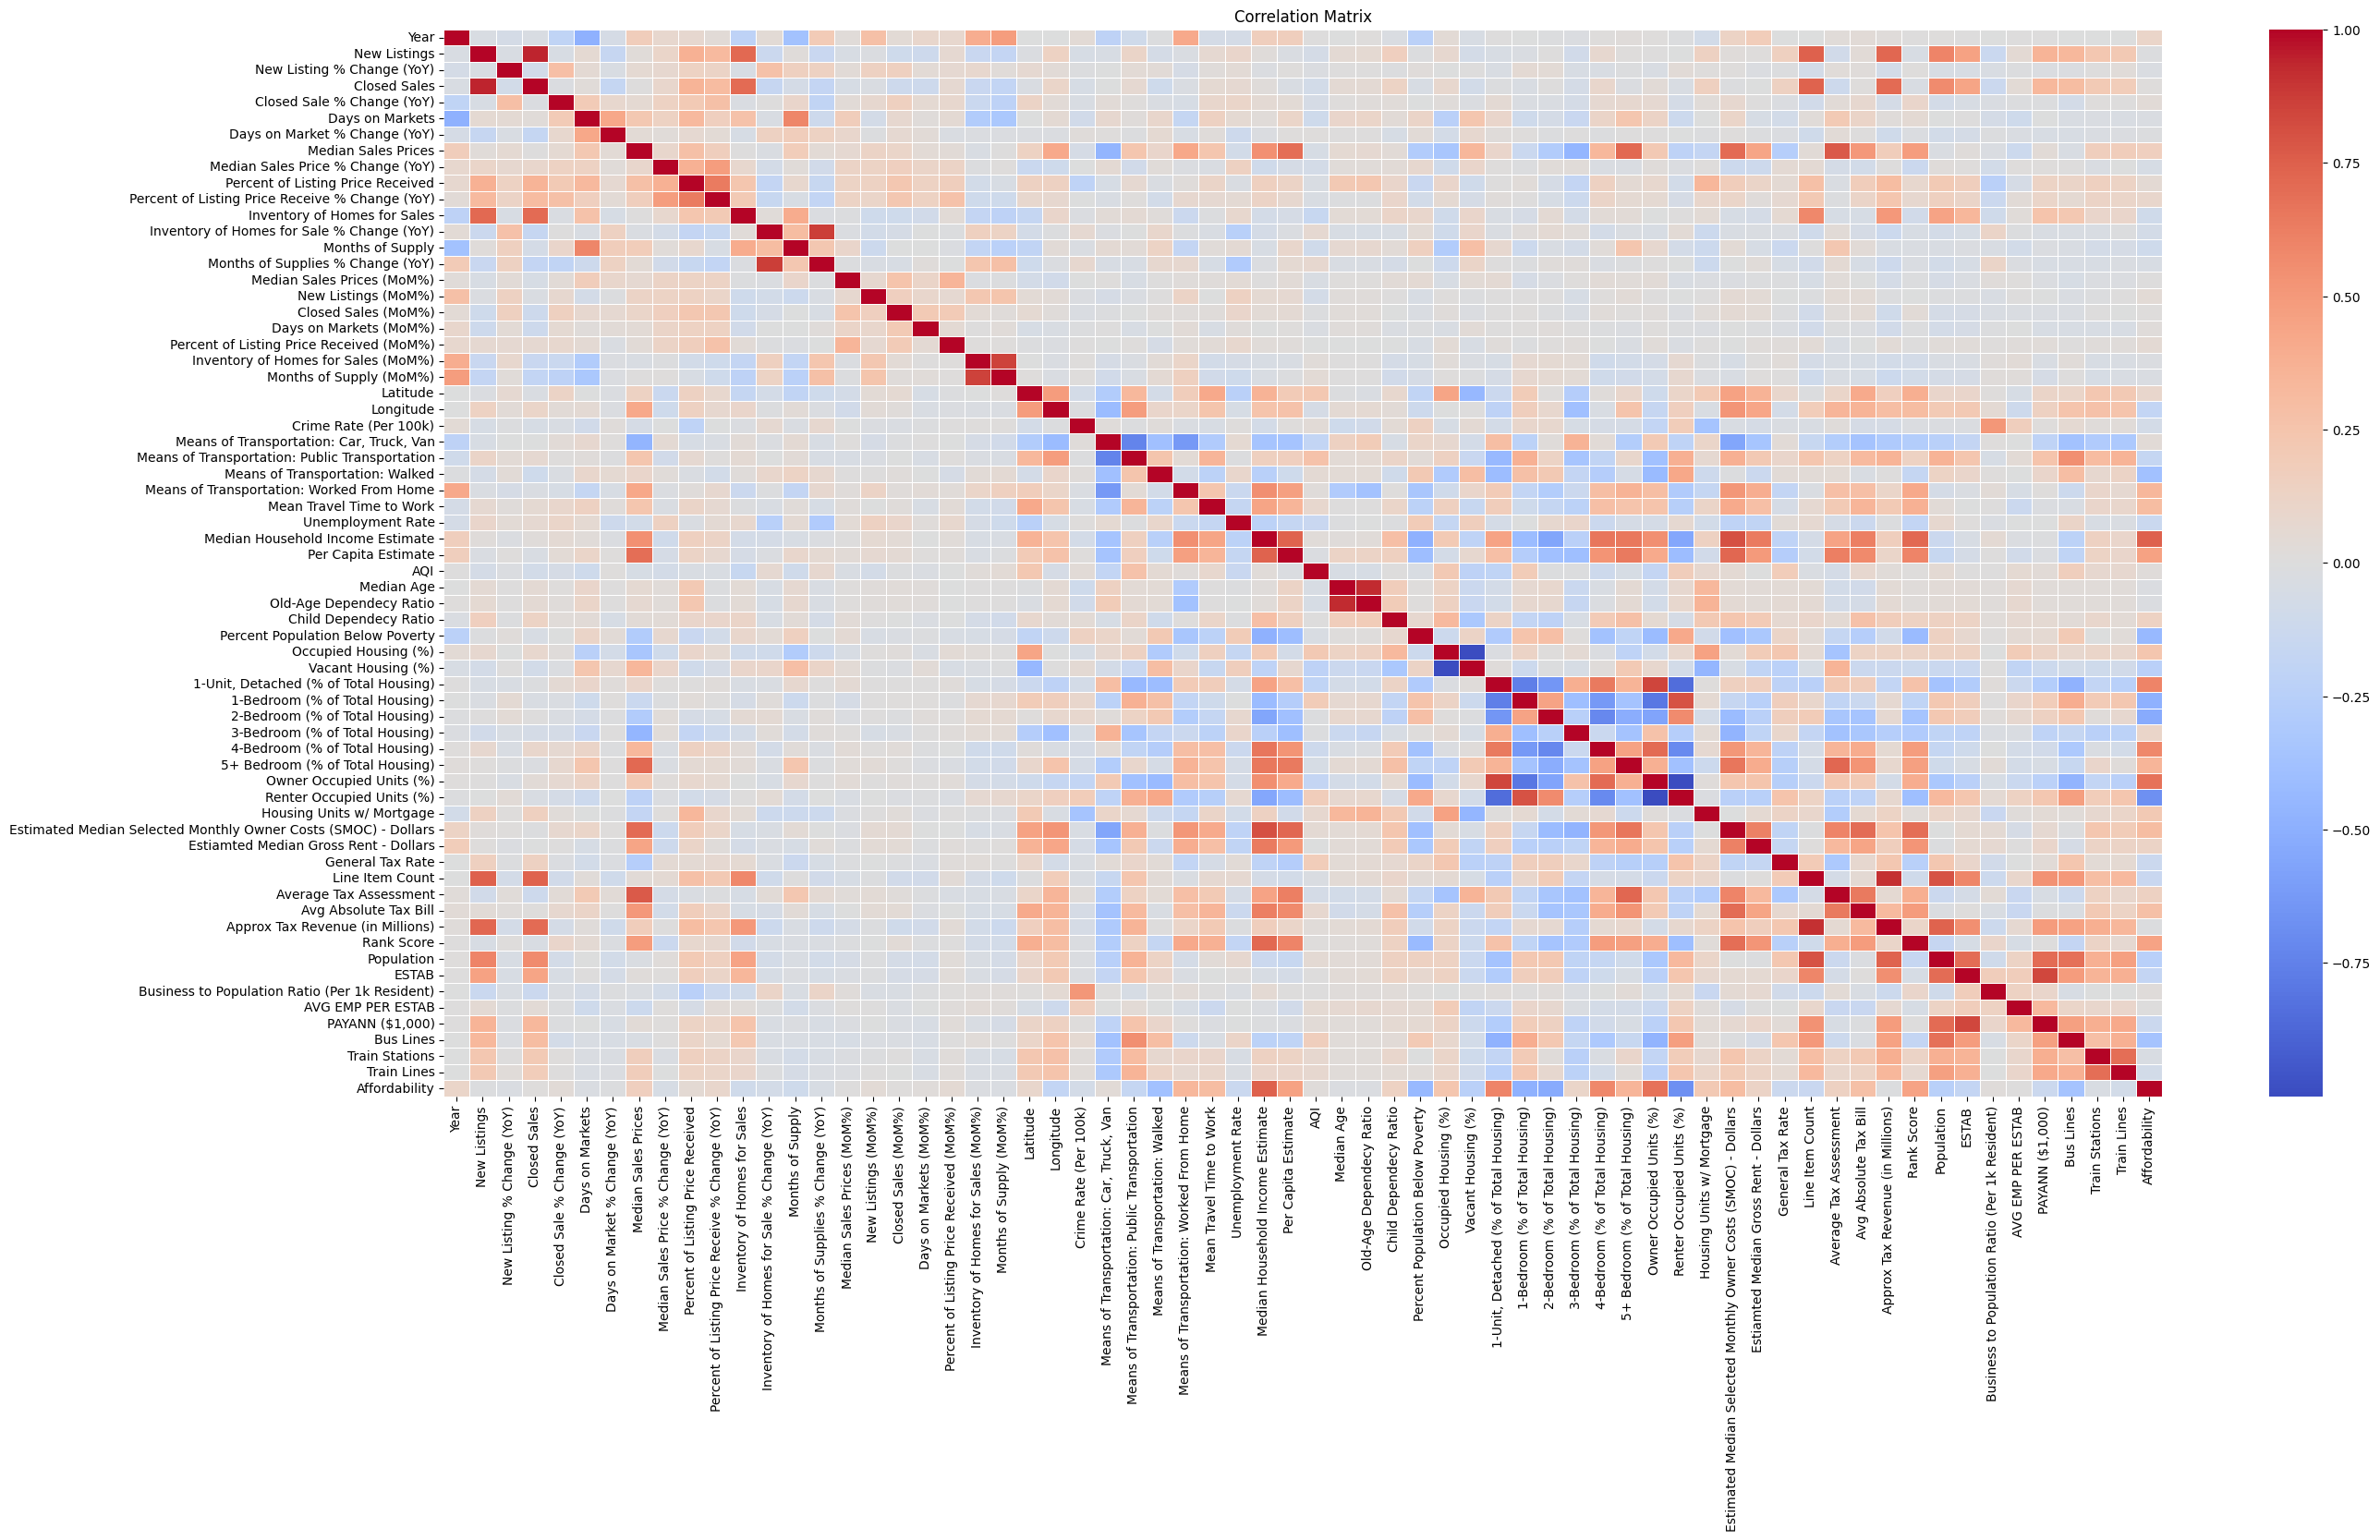

In [ ]:
plt.figure(figsize=(30,15))
correlation_matrix = test_df[[column for column in test_df.columns if column not in ['Municipality', 'County'] and 'Z-Score' not in column]].corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidth=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
test_df.describe()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000
mean,2020.500000,14.866221,0.034724,12.247382,0.118484,47.423411,0.032384,4.576522e+05,0.125662,0.910786,-0.023286,38.364693,-0.244118,3.158296,-0.213125,0.028077,0.081817,0.121461,0.166561,-0.001877,0.006965,0.011303,40.332256,-74.551975,1799.002219,80.773548,6.020372,2.131897,9.439564,31.322101,5.851134,103588.868591,50961.383394,36.670861,-1.814839e+06,-2.117330e+06,33.967922,9.815374,89.107305,10.892877,66.406307,10.896234,22.024365,35.704809,22.841742,6.859392,73.005445,26.994601,64.290563,2606.634953,1557.877243,0.030961,4368.992287,3.557019e+05,8650.129769,38.866275,0.567177,16133.614791,557.496824,61.270535,12.670685,5.801345e+05,2.571688,0.390200,0.346642,114.551488
std,1.118288,14.890832,0.326562,13.104967,0.421739,25.656069,0.433674,3.565324e+05,0.238785,0.222257,0.098223,50.092766,0.273749,2.351920,0.352679,0.101720,0.234710,0.223328,0.525438,0.034610,0.094713,0.089931,0.559045,0.403812,6516.984848,11.256870,7.132511,2.630096,7.299381,5.353362,2.798703,38325.344370,21536.653139,5.138986,3.474443e+07,3.751974e+07,9.983423,9.438693,15.388601,15.388761,22.985807,8.352392,10.312900,10.693449,11.681165,7.187684,18.280283,18.280293,10.159222,683.364208,447.548157,0.022394,5144.232116,3.342660e+05,4033.162089,44.415133,0.217853,25783.778378,801.846558,170.335486,9.628663,1.143374e+06,4.180867,0.765942,0.731611,24.235025
min,2019.000000,0.000000,-1.000000,0.000000,-0.857000,0.000000,-0.934000,0.000000e+00,-0.806333,0.000000,-0.750000,0.000000,-1.000000,0.000000,-1.000000,-0.584038,-0.583333,-0.583333,-0.

In [ ]:
mask = test_df[test_df['Housing Units w/ Mortgage'] < 0]

In [ ]:
test_df.loc[mask.index, 'Housing Units w/ Mortgage'] = 0

In [ ]:
mask = test_df[test_df['Child Dependecy Ratio'] < 0]

In [ ]:
test_df.loc[mask.index, 'Child Dependecy Ratio'] = 0

In [ ]:
"""
Necessary Data Handling To Remove Skew and Normalize Data:
If the data could naturally have a zero as a value, what lower limit could we add on the same scale of that feature?
- Do you add the equivalent of one on that scale or to I use the average?

Add Constant (zeros naturally occur):
- ['New Listings', 'Closed Sales', 'Days on Markets', 'Inventory of Homes for Sales', 'Months of Supply',
'Percent of Listing Price Received', 'Means of Transportation: Public Transportation', 'Means of Transportation: Walked',
'Means of Transportation: Worked From Home', 'Vacant Housing (%)' , '1-Bedroom (% of Total Housing)', '2-Bedroom (% of Total Housing)',
'3-Bedroom (% of Total Housing)', '4-Bedroom (% of Total Housing)', '5+ Bedroom (% of Total Housing)',
'Renter Occupied Units (%)', 'Child Dependecy Ratio', 'Housing Units w/ Mortgage', 'Business to Population Ratio (Per 1k Resident)',
'PAYANN ($1000)', 'Bus Lines', 'Train Stations', 'Train Lines', 'Closed Sale % Change (YoY)', 'Days on Market % Change (YoY)',
'Median Sales Price % Change (YoY)', 'Percent of Listing Price Receive % Change (YoY)', 'Median Sales Prices (MoM%)',
'New Listings (MoM%)', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)', 'Percent of Listing Price Received (MoM%)',
'Inventory of Homes for Sales (MoM%)', 'Months of Supply (MoM%)']

Add 100k:
Median Sales Price

Add two (2):
['New Listing % Change (YoY)', 'Inventory of Homes for Sale % Change (YoY)', 'Months of Supplies % Change (YoY)']

Add mean (zeros may not naturally occur):
['Crime Rate (Per 100k)', 'Line Item Count', 'Average Tax Assessment', 'Avg Absolute Tax Bill',
'Approx Tax Revenue (in Millions)', 'ESTAB', 'AVG EMP PER ESTAB', 'EMP', 'AVG PAYANN]


Transformations
- Use sqrt on Percent of Listing Price Received, Train Stations, Train Lines
- Try cubed root on General Tax Rate
Drop:
- Means of Transportation: Bicycle
"""

'\nNecessary Data Handling:\nIf the data could naturally have a zero as a value, what lower limit could we add on the same scale of that feature?\n- Do you add the equivalent of one on that scale or to I use the average?\n\nAdd Constant (zeros naturally occur):\n- +1 to New Listings, Closed Sales, Days on Markets, Inventory, Months of Supply, \nPercent of Listing Price Received, Means of Public Public Transportation, Walked, Work From Home,\nVacant Housing, 1-5 Bedroom, Owner Occupied, Renter Occupied, Child Dependecy, Hosuing Units w/ Mortgage,\n\n- +100k to Median Sales Price\n\nAdd mean (zeros may not naturally occur):\n- Crime Rate (Per 100k)\n- Line Item Count\n- Average Tax Assessment\n- Avg Absolute Tax Bill\n- Approx Tax Revenue (in Millions)\n- ESTAB\n- Business to Population Ratio (Per 1k Resident)\n\n\nTransformations\n- Use sqrt on Percent of Listing Price Received\n- Try cubed root on General Tax Rate\nDrop:\n- Means of Transportation: Bicycle\n'

In [ ]:
impute_mean = ['Crime Rate (Per 100k)', 'Line Item Count', 'Average Tax Assessment', 'Avg Absolute Tax Bill',
'Approx Tax Revenue (in Millions)', 'ESTAB', 'AVG EMP PER ESTAB', 'Median Age', 'Old-Age Dependecy Ratio',
               'EMP', 'AVG PAYANN PER EMP', 'Population']

impute_100k = ['Median Sales Price']

add_1 = ['New Listings', 'Closed Sales', 'Days on Markets', 'Inventory of Homes for Sales', 'Months of Supply',
'Percent of Listing Price Received', 'Means of Transportation: Public Transportation', 'Means of Transportation: Walked',
'Means of Transportation: Worked From Home', 'Vacant Housing (%)' , '1-Bedroom (% of Total Housing)', '2-Bedroom (% of Total Housing)',
'3-Bedroom (% of Total Housing)', '4-Bedroom (% of Total Housing)', '5+ Bedroom (% of Total Housing)',
'Renter Occupied Units (%)', 'Child Dependecy Ratio', 'Housing Units w/ Mortgage', 'Business to Population Ratio (Per 1k Resident)',
'PAYANN ($1000)', 'Bus Lines', 'Train Stations', 'Train Lines', 'Closed Sale % Change (YoY)', 'Days on Market % Change (YoY)',
'Median Sales Price % Change (YoY)', 'Percent of Listing Price Receive % Change (YoY)', 'Median Sales Prices (MoM%)',
'New Listings (MoM%)', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)', 'Percent of Listing Price Received (MoM%)',
'Inventory of Homes for Sales (MoM%)', 'Months of Supply (MoM%)', 'NL% of Total Inventory (State)', 'NL% of Total Inventory (County)',
'County Sales Attr. By City', 'State Sales Attr. By City','County Inventory Attr. By City', 'State Inventory Attr. By City',
'County New Listings Attr. By City', 'State New Listings Attr. By City', 'Means of Transportation: Car, Truck, Van', 'Owner Occupied Units (%)']

add_2 = ['New Listing % Change (YoY)', 'Inventory of Homes for Sale % Change (YoY)', 'Months of Supplies % Change (YoY)']

In [ ]:
for column in test_df.columns:

  if column in add_1:
    # Add 1
    test_df[column] = test_df[column] + 1

  if column in add_2:
    # Add 2
    test_df[column] = test_df[column] + 2

  elif column in impute_mean:
    # Add mean
    mean_mask = test_df[column] == 0
    test_df.loc[test_df[mean_mask].index, column] = test_df[column].mean()

  elif column == 'Median Sales Prices':
    # Add 100k
    test_df[column] = test_df[column] + 100000

  else:
    # Skip column
    pass

<ipython-input-17-94814b461479>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column] = test_df[column] + 1
<ipython-input-17-94814b461479>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[column] = test_df[column] + 2
<ipython-input-17-94814b461479>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [ ]:
test_df.describe()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000
mean,2020.500000,15.866221,2.034724,13.247382,1.118484,48.423411,1.032384,5.576522e+05,1.125662,1.910786,0.976714,39.364693,1.755882,4.158296,1.786875,1.028077,1.081817,1.121461,1.166561,0.998123,1.006965,1.011303,40.332256,-74.551975,1812.878370,81.773548,7.020372,3.131897,10.439564,31.322101,5.851134,103588.868591,50961.383394,36.670861,-1.814839e+06,-2.117330e+06,34.967922,9.815374,89.107305,11.892877,66.406307,11.896234,23.024365,36.704809,23.841742,7.859392,74.005445,27.994601,65.290563,2606.634953,1557.877243,0.030961,4567.222427,3.718408e+05,9042.603896,40.664986,0.567177,16572.823905,578.744434,62.270535,13.153597,5.801345e+05,3.571688,1.390200,1.346642,114.551488
std,1.118288,14.890832,0.326562,13.104967,0.421739,25.656069,0.433674,3.565324e+05,0.238785,0.222257,0.098223,50.092766,0.273749,2.351920,0.352679,0.101720,0.234710,0.223328,0.525438,0.034610,0.094713,0.089931,0.559045,0.403812,6515.053670,11.256870,7.132511,2.630096,7.299381,5.353362,2.798703,38325.344370,21536.653139,5.138986,3.474443e+07,3.751974e+07,9.983423,9.438693,15.388601,15.388761,22.985807,8.352392,10.312900,10.693449,11.681165,7.187684,18.280283,18.280293,10.159222,683.364208,447.548157,0.022394,5055.427970,3.251614e+05,3565.921674,43.583555,0.217853,25642.172061,794.138140,170.335486,9.292806,1.143374e+06,4.180867,0.765942,0.731611,24.235025
min,2019.000000,1.000000,1.000000,1.000000,0.143000,1.000000,0.066000,1.000000e+05,0.193667,1.000000,0.250000,1.000000,1.000000,1.000000,1.000000,0.415962,0.416667,0.416667,0.377778,0.50000

In [ ]:
test_df.shape

(2204, 66)

In [ ]:
skewness_dict = {}

for column in test_df.columns:

  skewness_dict[column] = test_df[column].skew()


In [ ]:
# If the data is heavily left skewed and the data is decimal numbers, use the inverse log (e^x)
# If the data is hevily right skewed and the data is large numbers, use squared or cubed root
from pprint import pprint

pprint(skewness_dict)

{'1-Bedroom (% of Total Housing)': 0.9244466300042825,
 '1-Unit, Detached (% of Total Housing)': -0.707592943624275,
 '2-Bedroom (% of Total Housing)': 0.6323226928678018,
 '3-Bedroom (% of Total Housing)': 0.46972516330607894,
 '4-Bedroom (% of Total Housing)': 0.5359691055231384,
 '5+ Bedroom (% of Total Housing)': 2.4893498712130446,
 'AQI': -0.8702388007653391,
 'AVG EMP PER ESTAB': 6.820060870683535,
 'Affordability': 0.15429853121586795,
 'Approx Tax Revenue (in Millions)': 2.26977605104065,
 'Average Tax Assessment': 3.8560854365029815,
 'Avg Absolute Tax Bill': 1.3351763106443446,
 'Bus Lines': 3.9685641806983956,
 'Business to Population Ratio (Per 1k Resident)': 10.290452019421155,
 'Child Dependecy Ratio': 1.5451011700593968,
 'Closed Sale % Change (YoY)': 3.7630756413972555,
 'Closed Sales': 2.2022305359572503,
 'Closed Sales (MoM%)': 3.135634706373158,
 'Crime Rate (Per 100k)': 18.63033347573468,
 'Days on Market % Change (YoY)': 3.804561175717412,
 'Days on Markets': 1.54

In [ ]:
transformed_df = pd.DataFrame({}, columns=test_df.columns)
transformed_df.head()

,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability


In [ ]:
# Apply slightly modified transformations based on the current scale of the data
# Larger numbers may require slightly weaker transformations
transformed_skewness_dict = {}

for key, value in skewness_dict.items():
  try:
    if 0.5 < value < 1.75:
      transformed_skewness_dict[key] = ((test_df[key])**(1/3)).skew()
      transformed_df[key] = (test_df[key])**(1/3)

    elif 1.75 < value < 3.0:
      transformed_skewness_dict[key] = ((test_df[key])**(1/4)).skew()
      transformed_df[key] = (test_df[key])**(1/4)

    elif value > 3.0:
      if key in ['Train Lines', 'Train Stations', 'Closed Sales (MoM%)', 'Days on Markets (MoM%)', 'Median Sales Prices (MoM%)']:
        transformed_skewness_dict[key] = ((test_df[key])**(1/15)).skew()
        transformed_df[key] = (test_df[key])**(1/15)
      elif key in ['General Tax Rate', 'New Listing % Change (YoY)']:
        transformed_skewness_dict[key] = ((test_df[key])**(1/10)).skew()
        transformed_df[key] = (test_df[key])**(1/10)
      else:
        transformed_skewness_dict[key] = (np.log(test_df[key])).skew()
        transformed_df[key] = np.log(test_df[key])

    elif -1.75 < value < -0.5:
      transformed_skewness_dict[key] = ((test_df[key])**(3)).skew()
      transformed_df[key] = (test_df[key])**(3)

    elif -3.0 < value < -1.75:
      if key in ['Percent of Listing Price Received', 'Median Age']:
        transformed_skewness_dict[key] = ((test_df[key])**(14)).skew()
        transformed_df[key] = (test_df[key])**(14)
      elif key in ['Occupied Housing (%)', 'Old-Age Dependecy Ratio']:
        transformed_skewness_dict[key] = ((test_df[key])**(10)).skew()
        transformed_df[key] = (test_df[key])**(10)
      else:
        transformed_skewness_dict[key] = ((test_df[key])**(4)).skew()
        transformed_df[key] = (test_df[key])**(4)

    elif value < -3.0:
      transformed_skewness_dict[key] = (np.exp(test_df[key])).skew()
      transformed_df[key] = np.exp(test_df[key])

    else:
      transformed_skewness_dict[key] = test_df[key].skew()
      transformed_df[key] = test_df[key]

  except KeyError:
    pass

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1256: RuntimeWarning: invalid value encountered in subtract
  adjusted = values - mean
/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1259: RuntimeWarning: overflow encountered in square
  adjusted2 = adjusted**2
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [ ]:
pprint(transformed_skewness_dict)

{'1-Bedroom (% of Total Housing)': -0.028884595439080216,
 '1-Unit, Detached (% of Total Housing)': 0.43276378726023323,
 '2-Bedroom (% of Total Housing)': -0.3600852041294799,
 '3-Bedroom (% of Total Housing)': 0.46972516330607894,
 '4-Bedroom (% of Total Housing)': -0.39020390736271404,
 '5+ Bedroom (% of Total Housing)': 0.8407534976299115,
 'AQI': -0.2279950639695305,
 'AVG EMP PER ESTAB': 0.2864896924303775,
 'Affordability': 0.15429853121586795,
 'Approx Tax Revenue (in Millions)': 0.12198127670519823,
 'Average Tax Assessment': 0.2535812495550695,
 'Avg Absolute Tax Bill': 0.13225833855905175,
 'Bus Lines': 0.6863040743450897,
 'Business to Population Ratio (Per 1k Resident)': -0.4930037872154887,
 'Child Dependecy Ratio': -1.2330337914208058,
 'Closed Sale % Change (YoY)': -0.025194505523507237,
 'Closed Sales': 0.3917378188531583,
 'Closed Sales (MoM%)': 1.1723584054338907,
 'Crime Rate (Per 100k)': 0.2839171794906648,
 'Days on Market % Change (YoY)': 0.03161396767100999,
 'D

In [ ]:
transformed_df.describe()

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)


,Year,New Listings,New Listing % Change (YoY),Closed Sales,Closed Sale % Change (YoY),Days on Markets,Days on Market % Change (YoY),Median Sales Prices,Median Sales Price % Change (YoY),Percent of Listing Price Received,Percent of Listing Price Receive % Change (YoY),Inventory of Homes for Sales,Inventory of Homes for Sale % Change (YoY),Months of Supply,Months of Supplies % Change (YoY),Median Sales Prices (MoM%),New Listings (MoM%),Closed Sales (MoM%),Days on Markets (MoM%),Percent of Listing Price Received (MoM%),Inventory of Homes for Sales (MoM%),Months of Supply (MoM%),Latitude,Longitude,Crime Rate (Per 100k),"Means of Transportation: Car, Truck, Van",Means of Transportation: Public Transportation,Means of Transportation: Walked,Means of Transportation: Worked From Home,Mean Travel Time to Work,Unemployment Rate,Median Household Income Estimate,Per Capita Estimate,AQI,Median Age,Old-Age Dependecy Ratio,Child Dependecy Ratio,Percent Population Below Poverty,Occupied Housing (%),Vacant Housing (%),"1-Unit, Detached (% of Total Housing)",1-Bedroom (% of Total Housing),2-Bedroom (% of Total Housing),3-Bedroom (% of Total Housing),4-Bedroom (% of Total Housing),5+ Bedroom (% of Total Housing),Owner Occupied Units (%),Renter Occupied Units (%),Housing Units w/ Mortgage,Estimated Median Selected Monthly Owner Costs (SMOC) - Dollars,Estiamted Median Gross Rent - Dollars,General Tax Rate,Line Item Count,Average Tax Assessment,Avg Absolute Tax Bill,Approx Tax Revenue (in Millions),Rank Score,Population,ESTAB,Business to Population Ratio (Per 1k Resident),AVG EMP PER ESTAB,"PAYANN ($1,000)",Bus Lines,Train Stations,Train Lines,Affordability
count,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2.204000e+03,2204.000000,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2.204000e+03,2204.000000,2.204000e+03,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000,2204.000000
mean,2020.500000,1.849340,1.191753,1.764937,0.055865,3.514034,-0.034564,26.536110,1.025888,13625.001667,2.667381,3.108067,1.148789,1.395040,1.152536,1.001599,0.059338,1.006663,1.008097,2.714659,0.003111,1.002912,40.332256,-74.551975,6.932160,4.907871e+07,1.511379,0.925518,2.145573,31.322101,1.760613,46.282619,-inf,52099.294694,3.450925e+29,2.369088e+170,3.238513,1.659719,1.023129e+42,2.078947,389465.731945,2.147596,2.775835,36.704809,2.791809,1.583015,4.734716e+05,2.890393,2.036899e+07,2606.634953,11.495313,0.670550,7.488366,12.601461,20.495113,2.285498,0.567177,9.020656,5.626606,3.399061,2.434043,-inf,0.883065,1.065139,1.014699,114.551488
std,1.118288,0.436813,0.044771,0.417466,0.330916,0.714180,0.357772,3.713199,0.053656,6504.344493,0.228038,1.110184,0.041815,0.172138,0.052030,0.005808,0.191764,0.011652,0.015696,0.081881,0.085136,0.028959,0.559045,0.403812,0.915603,2.018637e+07,0.342713,0.619766,0.652159,5.353362,0.269601,5.634478,NaN,18988.773640,1.140690e+31,inf,0.328200,0.348144,3.401340e+42,0.792440,285093.955761,0.556745,0.447662,10.693449,0.504637,0.304876,2.599320e+05,0.664127,9.348912e+06,683.364208,1.055287,0.147806,1.968045,0.639653,2.648771,0.634750,0.217853,1.258612,1.369885,1.161052,0.512826,NaN,0.820015,0.115638,0.025378,24.235025
min,2019.000000,1.000000,1.000000,1.000000,-1.944911,1.000000,-2.718101,17.782794,0.663382,1.000000,1.284025,0.000000,1.000000,1.000000,1.000000,0.943200,-0.875469,0.943306,0.937164,1.648721,-0.470004,0.858328,38.933330,-75.503451,2.590017,1.000000e+00,1.000000,0.0

In [ ]:
transformed_data = transformed_df[[i for i in transformed_df.columns if i not in ['Per Capita Estimate', 'Old-Age Dependecy Ratio', 'Median Age', 'PAYANN ($1,000)']]]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

standard_scaler = StandardScaler()
standardized_data = standard_scaler.fit_transform(transformed_data)

In [ ]:
# Very high dimensionality and PCA reduction loses too much data
pca_data = PCA(n_components=2).fit(standardized_data)
print(pca_data.explained_variance_ratio_)

[0.16348044 0.13335007]


In [ ]:
from umap import UMAP

umap_data = UMAP(n_components=3).fit(standardized_data)

In [ ]:
# plt.style.use('_mpl-gallery')
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,10))
import plotly.express as px
import plotly.io as pio

fig_3d = px.scatter_3d(umap_data.embedding_, x=0, y=1, z=2)
fig_3d.show()
pio.write_image(fig_3d, 'umap_3d.png')


In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

score_dict = {}

for clf, clf_name in zip([KMeans(), DBSCAN(), HDBSCAN()], ['KMeans', 'DBSCAN', 'HDBSCAN']):
  if clf_name == 'KMeans':
    score_dict.setdefault(clf_name, {})
    for n_clusters in range(2,11):

      clf.set_params(n_clusters=n_clusters)
      kmeans = clf.fit(umap_data.embedding_)
      score_dict[clf_name][n_clusters] = {'Silhouette Score': silhouette_score(umap_data.embedding_, kmeans.labels_),
                              'Davies Bouldin Score': davies_bouldin_score(umap_data.embedding_, kmeans.labels_)
                              }
  elif clf_name == 'DBSCAN':
    score_dict.setdefault(clf_name, {})
    for eps in np.arange(0.5, 1.1, 0.1):
      clf.set_params(n_jobs=-1, eps=eps)
      dbscan = clf.fit(umap_data.embedding_)
      score_dict[clf_name][len(np.unique(dbscan.labels_))] = {'Epsilon': eps,
                              'Silhouette Score': silhouette_score(umap_data.embedding_, dbscan.labels_),
                              'Davies Bouldin Score': davies_bouldin_score(umap_data.embedding_, dbscan.labels_)
                              }
  elif clf_name == 'HDBSCAN':
    score_dict.setdefault(clf_name, {})
    for eps in np.arange(0.0, 1.1, 0.1):
      clf.set_params(n_jobs=-1, cluster_selection_epsilon=eps)
      dbscan = clf.fit(umap_data.embedding_)
      score_dict[clf_name][len(np.unique(dbscan.labels_))] = {'Epsilon': eps,
                              'Silhouette Score': silhouette_score(umap_data.embedding_, dbscan.labels_),
                              'Davies Bouldin Score': davies_bouldin_score(umap_data.embedding_, dbscan.labels_)
                              }

In [ ]:
pprint(score_dict)

{'DBSCAN': {3: {'Davies Bouldin Score': 0.6118316407616776,
                'Epsilon': 1.0999999999999999,
                'Silhouette Score': 0.16035819},
            5: {'Davies Bouldin Score': 0.6822854130326634,
                'Epsilon': 0.7,
                'Silhouette Score': -0.06148707},
            6: {'Davies Bouldin Score': 1.5534087145070978,
                'Epsilon': 0.5,
                'Silhouette Score': -0.04599159}},
 'HDBSCAN': {3: {'Davies Bouldin Score': 0.6118316407616776,
                 'Epsilon': 1.0,
                 'Silhouette Score': 0.16035819},
             4: {'Davies Bouldin Score': 0.5676261042439127,
                 'Epsilon': 0.7000000000000001,
                 'Silhouette Score': 0.14367534},
             6: {'Davies Bouldin Score': 1.65986621821823,
                 'Epsilon': 0.5,
                 'Silhouette Score': -0.0763216},
             15: {'Davies Bouldin Score': 1.7048593509444288,
                  'Epsilon': 0.4,
                  

In [ ]:
target_clf = KMeans(n_clusters=8)
target_clf.fit(umap_data.embedding_)

labels = target_clf.labels_

fig = px.scatter_3d(umap_data.embedding_, x=0, y=1, z=2, color=labels)
fig.show()

In [ ]:
!pip install -U kaleido

In [ ]:
umap_df = pd.DataFrame(umap_data.embedding_, columns=['x', 'y', 'z'])
umap_df['labels'] = labels

In [ ]:
umap_df.head()

,x,y,z,labels
0,7.846863,5.431742,3.977174,0
1,7.861142,5.482604,4.014451,0
2,7.775458,5.456089,4.117899,0
3,7.583876,5.473436,4.154543,0
4,4.704681,1.632570,3.009768,3


In [ ]:
import plotly.graph_objects as go
import imageio
import kaleido

# Create a figure
fig = go.Figure(data=[go.Scatter3d(x=umap_df['x'], y=umap_df['y'], z=umap_df['z'], mode='markers', marker=dict(color=umap_df['labels']))])

# Define angles for rotation
angles = np.linspace(0, 360, 30)  # 30 frames for a smooth rotation
images = []

for angle in angles:
    # Update the camera angle
    fig.update_layout(scene_camera=dict(eye=dict(x=np.cos(np.radians(angle)), y=np.sin(np.radians(angle)), z=0.5)))
    # Save each frame as a static image in memory
    img_bytes = fig.to_image(format="png")
    images.append(imageio.imread(img_bytes))

# Save images as a GIF
imageio.mimsave("Rotating Clusters UMAP.gif", images, duration=0.1)

<ipython-input-44-fe4cd84bbe33>:17: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [ ]:
# 3D Image Pre Labeling

import plotly.graph_objects as go
import imageio
import kaleido

# Create a figure
fig = go.Figure(data=[go.Scatter3d(x=umap_df['x'], y=umap_df['y'], z=umap_df['z'], mode='markers')])

# Define angles for rotation
angles = np.linspace(0, 360, 30)  # 30 frames for a smooth rotation
images = []

for angle in angles:
    # Update the camera angle
    fig.update_layout(scene_camera=dict(eye=dict(x=np.cos(np.radians(angle)), y=np.sin(np.radians(angle)), z=0.5)))
    # Save each frame as a static image in memory
    img_bytes = fig.to_image(format="png")
    images.append(imageio.imread(img_bytes))

# Save images as a GIF
imageio.mimsave("Rotating Clusters UMAP_PreLabel.gif", images, duration=0.1)

<ipython-input-46-3a92ead4638f>:19: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



In [ ]:
umap_df.to_excel('umap_df.xlsx')